# Introduction

I love Asana, I'm PM and they are product company.
I like data science. I wanna explore Asana and it's competitors. I also want to play with and learna about the BERT model. This will be a curiosity-driven journey, not sure where it'll end.


# Packages

In [1]:
# Package to store the versions of packages used
!pip install -q watermark

In [2]:
# Package to download the BERT models and process data
!pip install -q transformers

In [3]:
# Package for scrapping data on Google Store
# https://pypi.org/project/google-play-scraper/
!pip install -q google_play_scraper

In [4]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/BERT_App_Sentiment_Analysis")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Imports

# Data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from tqdm import tqdm
import datetime


# Deep Learning, NLP and metrics
import sklearn
import torch
import transformers 
from textwrap import wrap
from torch import nn, optim 
from torch.utils import data
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# Web Scrapping Imports
# https://pypi.org/project/Pygments/
import json
import pygments
import google_play_scraper
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

# Random Seed
#RANDOM_SEED = 99
#np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Package versions
%reload_ext watermark
%watermark -v -iv

pygments            2.1.3
torch               1.5.1+cu101
google_play_scraper 0.0.3.0
pandas              1.0.5
numpy               1.18.5
sklearn             0.22.2.post1
seaborn             0.10.1
json                2.0.9
transformers        3.0.2
matplotlib          3.2.2
CPython 3.6.9
IPython 5.5.0


# Web Scrapping

In [7]:
# Listing apps I want to gather data on
# They'll all be Asana's competitors on task management
# Took the apps from Asana's comparison page, plus a few other alternatives the app store recommends
# https://asana.com/compare
# Asana, Airtable, Basecamp, Jira, Microsoft To Do
# Monday.com, Smartsheet, Taskade, Trello, Wrike
# The google_play_scrapper documentations details how to get the url for each app
# https://github.com/facundoolano/google-play-scraper
apps_list = ['com.asana.app',
             'com.formagrid.airtable',
             'com.basecamp.bc3',
             'com.atlassian.android.jira.core',
             'com.microsoft.todos',
             'com.monday.monday',
             'com.smartsheet.android',
             'com.taskade.mobile',
             'com.trello',
             'com.wrike']

In [8]:
# List to store details from the apps
app_details = []

# Loop through the app list and retrieve details of each app
for ap in tqdm(apps_list):

    # Retrieve app details
    info = google_play_scraper.app(ap, lang='en', country='us')

    # Store the details
    app_details.append(info)

100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


In [9]:
# Function to print a request in JSON format
def print_json(json_object):

    # Generate json format
    json_str = json.dumps(json_object,
                          indent = 2,
                          sort_keys = True,
                          default = str)
    
    # The highlight function from pygments highlights the output text 
    # It uses different colorts to facilitate reading
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [10]:
# Check the result in JSON format
print_json(app_details[0])

{
  "adSupported": null,
  "androidVersion": "7.0",
  "androidVersionText": "7.0 and up",
  "appId": "com.asana.app",
  "comments": [
    "App works well but a feature that is seriously missing: to be able to add tasks under certain sections. Currently if you add a new task, it is placed right at the top of the list and you need to drag it down to the relavant section (which is a pain if you have a long list with numerous sections). Please sort this out, would be a game changer",
    "Their UI team has decided to cripple our ability to jot down tasks quickly by blocking the add button with a pop-up after creating each task. And then their suggestion button is broken which has led me to complain here instead of offering constructive suggestions directly. Asana is getting big and clumsy. v6.50.8",
    "Amazing, free app! Love the functionality and aesthetic! Was mentioned by Edmond Lau in the effective engineer and am glad I took a chance on it! This is hands out the best task managing a

In [11]:
# Put the retrieved information into a dataframe
df_app_details = pd.DataFrame(app_details)

In [12]:
# Save the dataframe to disk

# Retrieve datetime to stamp the file
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Save with current datetime
df_app_details.to_csv(f'data/app_details_{now}.csv', header=True, index=None)

In [13]:
df_app_details.head(3)

,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,histogram,price,free,currency,sale,saleTime,originalPrice,saleText,offersIAP,size,androidVersion,androidVersionText,developer,developerId,developerEmail,developerWebsite,developerAddress,privacyPolicy,developerInternalID,genre,genreId,icon,headerImage,screenshots,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,comments,appId,url
0,Asana: Your work manager,Asana is the work manager for teams. But bette...,Asana is the work manager for teams. But bette...,Organize. Plan. Get work done. #withAsana,Organize. Plan. Get work done. #withAsana,"1,000,000+",1000000,4.586184,31299,9591,"[1434, 478, 1278, 3222, 24885]",0,True,USD,False,None,None,None,None,14M,7.0,7.0 and up,"Asana, Inc.","Asana,+Inc.",support@asana.com,https://asana.com/product,None,http://www.asana.com/privacy,9027419648812383370,Business,BUSINESS,https://lh3.googleusercontent.com/EJEviNAy8fAd...,https://lh3.googleusercontent.com/4ts1ELx9Kpks...,[https://lh3.googleusercontent.com/a-c_cZ7cTlT...,https://www.youtube.com/embed/jY0-gsNImlk?ps=p...,https://i.ytimg.com/vi/jY0-gsNImlk/hqdefault.jpg,Everyone,None,None,None,"Feb 27, 2013",1595265487,6.50.8,🎵 Give a little bit...\r\nGive a little bit of...,🎵 Give a little bit...<br>Give a little bit of...,[App works well but a feature that is seriousl...,com.asana.app,https://play.google.com/store/apps/details?id=...
1,Airtable,Organize anything you can imagine with Airtabl...,Organize anything you can imagine with Airtabl...,Organize anything you can imagine with a moder...,Organize anything you can imagine with a moder...,"100,000+",100000,3.608108,1516,758,"[276, 133, 122, 358, 624]",0,True,USD,False,None,None,None,None,12M,5.0,5.0 and up,Airtable,8024614373053231272,droid@airtable.com,https://airtable.com/,None,https://airtable.com/privacy,8024614373053231272,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/0AKPNIi6-Dct...,https://lh3.googleusercontent.com/xlIqHp_kgI76...,[https://lh3.googleusercontent.com/u1iubbqRbdB...,https://www.youtube.com/embed/rydOfdGCOBU?ps=p...,https://i.ytimg.com/vi/rydOfdGCOBU/hqdefault.jpg,Everyone,None,None,None,"Sep 27, 2016",1595281514,1.3.4,Organize anything you can imagine with Airtabl...,Organize anything you can imagine with Airtabl...,[The Android app lacks a significant amount of...,com.formagrid.airtable,https://play.google.com/store/apps/details?id=...
2,Basecamp 3,<b>Use your company's Basecamp 3 account on-th...,<b>Use your company&#39;s Basecamp 3 account o...,"Basecamp 3, official Android version for the w...","Basecamp 3, official Android version for the w...","500,000+",500000,4.311558,4150,1514,"[260, 135, 312, 782, 2658]",0,True,USD,False,None,None,None,None,7.6M,6.0,6.0 and up,Basecamp,Basecamp,support@basecamp.com,https://basecamp.com,None,https://basecamp.com/privacy,8645525805030592144,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/Mx66p8uDSlbx...,https://lh3.googleusercontent.com/DhvIpWbDmOr1...,[https://lh3.googleusercontent.com/o_oaonXHNi5...,None,None,Everyone,None,None,None,"Oct 20, 2015",1582299579,3.18.9,🐛 Bug fixes and improved speed over slow networks,🐛 Bug fixes and improved speed over slow networks,[Very bad UX. 1) No progress (% wise) shown fo...,com.basecamp.bc3,https://play.google.com/store/apps/details?id=...


In [14]:
# List to store app reviews
app_reviews = []

# Loop to retrieve and store app reviews
for ap in tqdm(apps_list):

    # Extract sample reviews from reviews with different stars given
    for star in list(range(1, 6)):

        # Extract the most relevant and the most recent reviews
        for sort_order in [google_play_scraper.Sort.MOST_RELEVANT, google_play_scraper.Sort.NEWEST]:
            rvws, _ = google_play_scraper.reviews(ap,
                                                  lang='en',
                                                  country='us',
                                                  sort=sort_order,
                                                  count = 100 if star == 3 else 50,
                                                  filter_score_with = star)
            
            for r in rvws:
                r['sortOrder'] = 'most_relevant' if sort_order == google_play_scraper.Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap

            # Save reviews
            app_reviews.extend(rvws)

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


In [15]:
# Create a dataframe with the reviews
df_app_reviews = pd.DataFrame(app_reviews)

In [16]:
# Save the dataframe to disk

# Retrieve datetime to stamp the file
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Save with current datetime
df_app_reviews.to_csv(f'data/app_reviews_{now}.csv', header = True, index = None)

In [17]:
# Loading the csv with app reviews
df_reviews = pd.read_csv(f'data/app_reviews_{now}.csv')
df_reviews.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOFrr-TuGFhU9WiSFNSqYKYrn8ZvUiUZ-ljdC8O...,Erlang P,https://lh3.googleusercontent.com/-kp-Z4Cq91b4...,"Bug: ""Add Tag"" not working on android. ""Save"" ...",1,0,6.48.5,2020-07-09 12:00:33,NaN,NaN,most_relevant,com.asana.app
1,gp:AOqpTOGjmtD5IJRa-8Rk7hxS02RFs1oyJgdDwFOXbsj...,mrk 1,https://lh3.googleusercontent.com/-HCdJh-McJWE...,At first looked very promising (specially UI) ...,1,30,6.46.6,2020-06-11 23:50:05,NaN,NaN,most_relevant,com.asana.app
2,gp:AOqpTOGxrxWE5FRGajIqnVem0ZQSS4vtXtIkIN6shZZ...,Donna,https://lh3.googleusercontent.com/a-/AOh14Gil7...,I was charged $395.64 all at once after a free...,1,10,6.47.4,2020-06-18 23:18:04,Hi! I'm sorry to hear you have been charged af...,2020-06-23 23:21:07,most_relevant,com.asana.app


In [18]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5418 entries, 0 to 5417
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              5418 non-null   object
 1   userName              5418 non-null   object
 2   userImage             5418 non-null   object
 3   content               5417 non-null   object
 4   score                 5418 non-null   int64 
 5   thumbsUpCount         5418 non-null   int64 
 6   reviewCreatedVersion  4852 non-null   object
 7   at                    5418 non-null   object
 8   replyContent          1873 non-null   object
 9   repliedAt             1873 non-null   object
 10  sortOrder             5418 non-null   object
 11  appId                 5418 non-null   object
dtypes: int64(2), object(10)
memory usage: 508.1+ KB


Text(0, 0.5, 'Total')

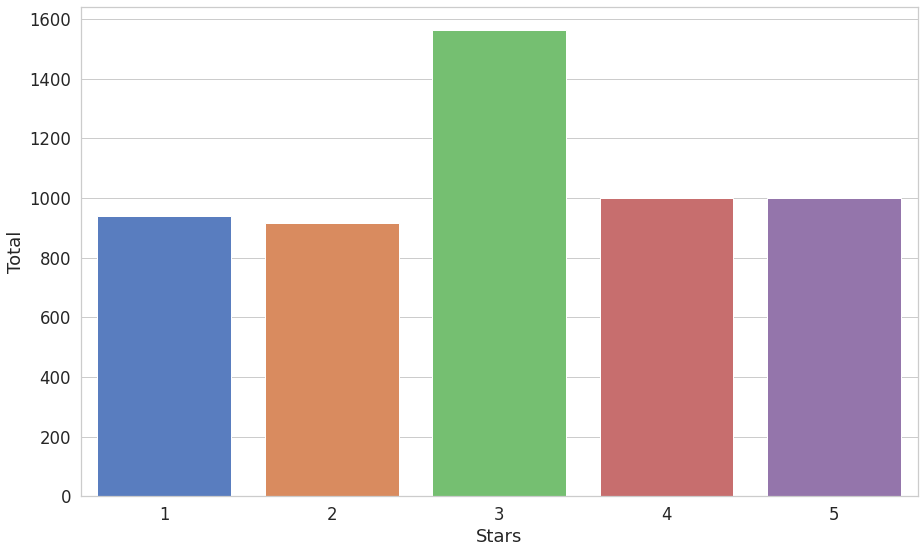

In [19]:
# Plot stars
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)
rcParams['figure.figsize'] = 15, 9
sns.countplot(df_reviews.score)
plt.xlabel('Stars')
plt.ylabel('Total')

Text(0, 0.5, 'Number of Samples')

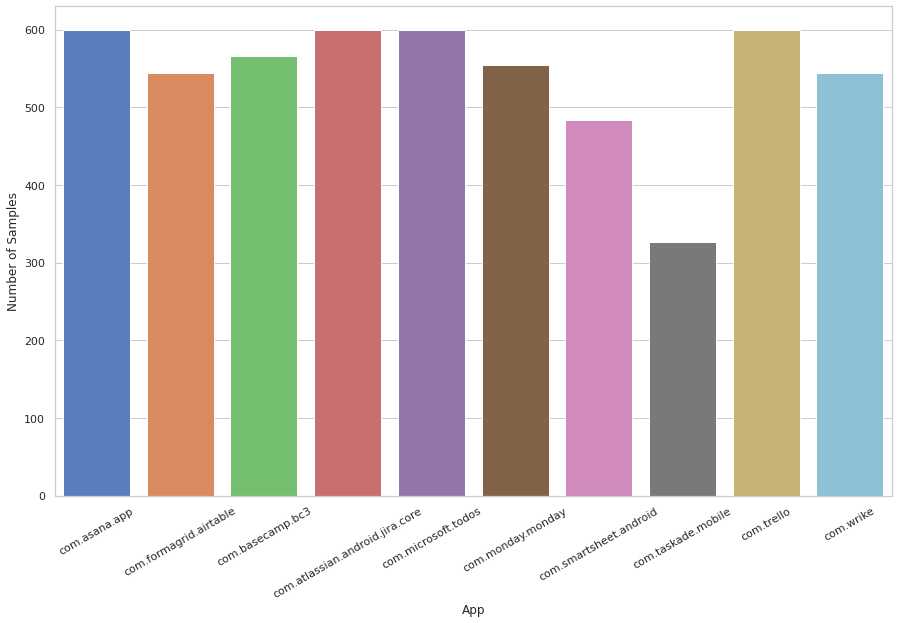

In [20]:
# Plot appId
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1)
rcParams['figure.figsize'] = 15, 9
ax = sns.countplot(df_reviews.appId)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.xlabel('App')
plt.ylabel('Number of Samples')

In [21]:
# Creating a pivot table to see which app x star combination didn't retrieve the desired amount of data
app_x_stars = df_reviews.groupby(['appId', 'score']).size().unstack()
app_x_stars

score,1,2,3,4,5
appId,,,,,
com.asana.app,100,100,200,100,100
com.atlassian.android.jira.core,100,100,200,100,100
com.basecamp.bc3,100,100,166,100,100
com.formagrid.airtable,100,100,144,100,100
com.microsoft.todos,100,100,200,100,100
com.monday.monday,100,100,154,100,100
com.smartsheet.android,100,100,84,100,100
com.taskade.mobile,40,16,70,100,100
com.trello,100,100,200,100,100


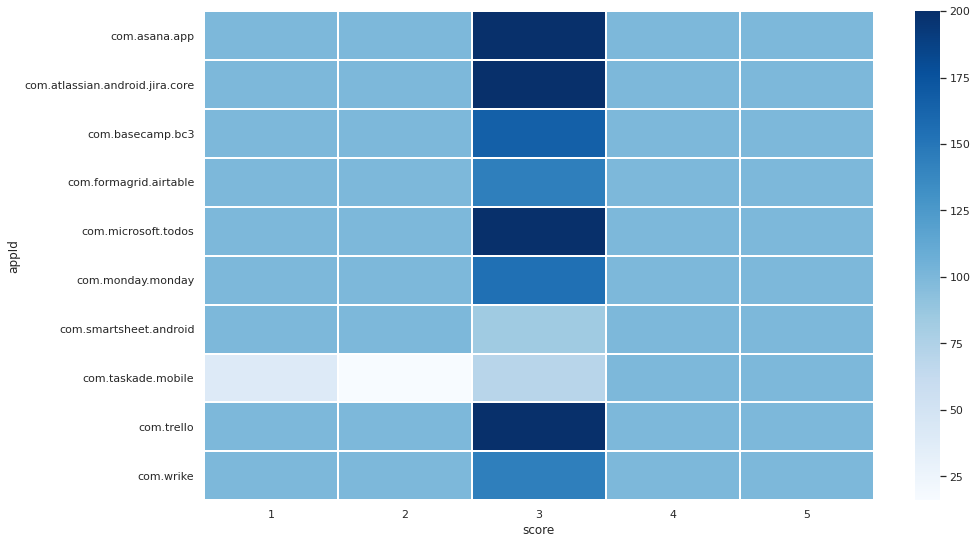

In [22]:
# Plotting app x stars as a heatmap
sns.heatmap(app_x_stars, linewidths=1, linecolor='white', cmap='Blues')

# Preprocessing

In [23]:
# Grouping function
# This will convert range of 1-5 star reviews into negative(0), neutral(1) and positive(2)
# This is why I've gathered twice as much data for 3 star reviews
def group_rating(rating):

    # initialize groups on -1 to catch any bugs
    grp_rating = -1 

    # Convert ratings to integers
    rating = int(rating)

    # If the rating is above 3, then positive (2)
    if rating > 3:
        grp_rating = 2
    
    # If rating is 3, then neutral (1)
    elif rating == 3:
        grp_rating = 1
    
    # If rating is below 3, then negative (0)
    else:
        grp_rating = 0
    
    return grp_rating

In [24]:
# Apply the function to the dataset and create a 'sentiment' column with the output
df_reviews['sentiment'] = df_reviews.score.apply(group_rating)

In [25]:
df_reviews.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOFrr-TuGFhU9WiSFNSqYKYrn8ZvUiUZ-ljdC8O...,Erlang P,https://lh3.googleusercontent.com/-kp-Z4Cq91b4...,"Bug: ""Add Tag"" not working on android. ""Save"" ...",1,0,6.48.5,2020-07-09 12:00:33,NaN,NaN,most_relevant,com.asana.app,0
1,gp:AOqpTOGjmtD5IJRa-8Rk7hxS02RFs1oyJgdDwFOXbsj...,mrk 1,https://lh3.googleusercontent.com/-HCdJh-McJWE...,At first looked very promising (specially UI) ...,1,30,6.46.6,2020-06-11 23:50:05,NaN,NaN,most_relevant,com.asana.app,0
2,gp:AOqpTOGxrxWE5FRGajIqnVem0ZQSS4vtXtIkIN6shZZ...,Donna,https://lh3.googleusercontent.com/a-/AOh14Gil7...,I was charged $395.64 all at once after a free...,1,10,6.47.4,2020-06-18 23:18:04,Hi! I'm sorry to hear you have been charged af...,2020-06-23 23:21:07,most_relevant,com.asana.app,0


In [26]:
# Shuffling the dataframe to avoid biasing the model later on
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)

In [27]:
# List with class names
class_names = ['negative', 'neutral', 'positive']

In [28]:
print(f'Negative: {(len(df_reviews[df_reviews.sentiment == 0])/len(df_reviews))}')
print(f'Neutral: {(len(df_reviews[df_reviews.sentiment == 1])/len(df_reviews))}')
print(f'Positive: {(len(df_reviews[df_reviews.sentiment == 2])/len(df_reviews))}')

Negative: 0.34256183093392395
Neutral: 0.2882982650424511
Positive: 0.36913990402362495


Text(0, 0.5, 'Total')

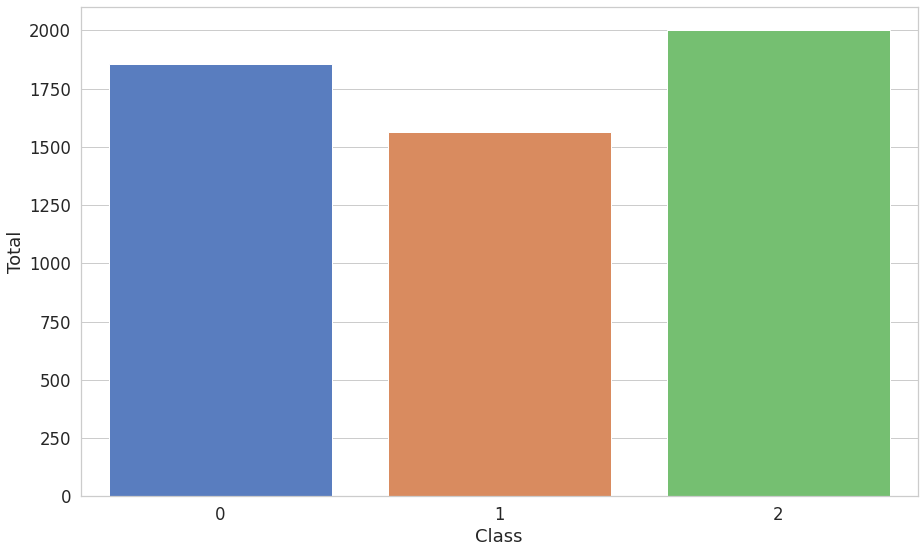

In [29]:
# Plot class distribution
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)
rcParams['figure.figsize'] = 15, 9
sns.countplot(df_reviews.sentiment)
plt.xlabel('Class')
plt.ylabel('Total')

Downloading the pre-treined BERT model.

List of available models: https://github.com/google-research/bert

In [30]:
# Model download
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [31]:
# Test text
test_text = 'Just a test sentence. Test 2.'
test_text

'Just a test sentence. Test 2.'

In [32]:
# Tokenize
tokens = tokenizer.tokenize(test_text)
tokens

['Just', 'a', 'test', 'sentence', '.', 'Test', '2', '.']

In [33]:
# Extract the token_ids
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[2066, 170, 2774, 5650, 119, 5960, 123, 119]

In [34]:
# Create the encoding object to format the data for the BERT model
encoding = tokenizer.encode_plus(test_text,
                                 max_length = 32,
                                 add_special_tokens = True,
                                 pad_to_max_length = True,
                                 return_attention_mask = True,
                                 return_token_type_ids = False,
                                 return_tensors = 'pt')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [35]:
# Print
encoding

{'input_ids': tensor([[ 101, 2066,  170, 2774, 5650,  119, 5960,  123,  119,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

Applying the BERT tokenizer to the dataset

In [36]:
# List for the tokens
token_length = []

In [37]:
# Drop NaN values before tokenizing
df_reviews = df_reviews.dropna(subset=['content'], how='all')
df_reviews.reset_index(inplace = True, drop=True)
df_reviews.shape

(5417, 13)

In [38]:
# Loop through the dataset content applying the tokenizer
for content in df_reviews.content:
    tokens = tokenizer.encode(content)
    token_length.append(len(tokens))

In [39]:
# Sample of contents
df_reviews.content.tail(5)

5412    My office just signed up for the website versi...
5413    I like the app, but I have to give it one star...
5414    While the interface is very clean. I have few ...
5415                              Still learning this one
5416    I like to have all tge features its website ha...
Name: content, dtype: object

Text(0.5, 0, 'Token Length')

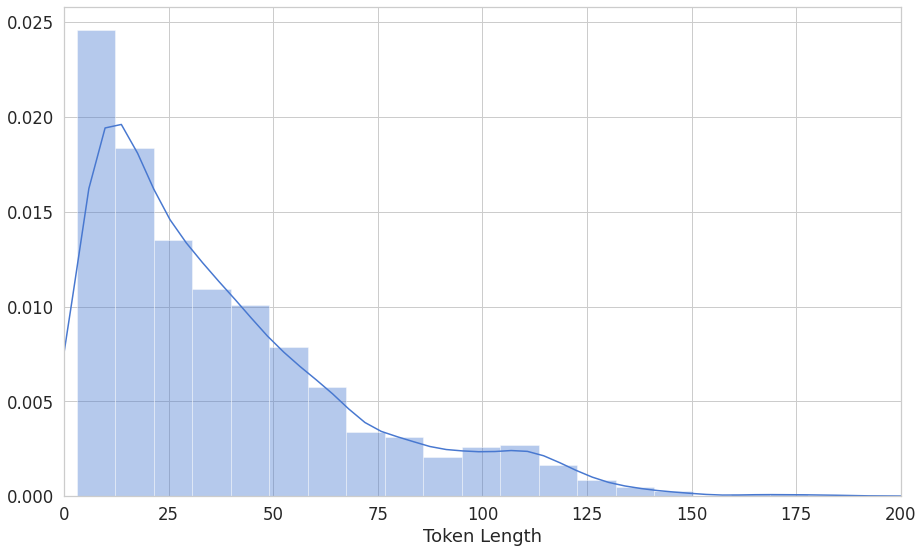

In [40]:
# Plot
ax = sns.distplot(token_length)
plt.xlim([0, 200])
plt.xlabel('Token Length')

# Configurations

In [41]:
# Model Hyperparameters
EPOCHS = 10
BATCH_SIZE = 16
MAX_LENGTH = 150
LEARNING_RATE = 0.00002 
'''
pent about 7 hours debugging this model to find out that the learning rate
has to be precisely 2e^-5 as anything else was cause the model not to learn at all
'''

'\npent about 7 hours debugging this model to find out that the learning rate\nhas to be precisely 2e^-5 as anything else was cause the model not to learn at all\n'

# Data Batching

In [42]:
class DataBatcher(data.Dataset):

    # Constructor
    def __init__(self, review, targets, tokenizer, max_len):

        # Initialize class atributes
        self.review = review
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    # Method to obtain each review
    def __getitem__(self, item):

        # Load a review
        review = str(self.review[item])

        # Create the review embedding
        encoding = tokenizer.encode_plus(review,
                                         max_length = self.max_len,
                                         truncation=True,
                                         add_special_tokens = True,
                                         pad_to_max_length = True,
                                         return_attention_mask = True,
                                         return_token_type_ids = False,
                                         return_tensors = 'pt')
        
        # Among the methods returns, there is the attention mask
        return {'review_text': review,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(self.targets[item], dtype = torch.long)}

In [43]:
# This function creates a data loader to convert the dataset to the BERT format
# torch.utils.data.dataloader.DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = DataBatcher(review = df.content.to_numpy(),
                     targets = df.sentiment.to_numpy(),
                     tokenizer = tokenizer,
                     max_len = max_len)
    
    return data.DataLoader(ds, batch_size = batch_size, num_workers = 4)

In [44]:
# Train test split
df_train, df_test = train_test_split(df_reviews, test_size = 0.2) #, random_state = RANDOM_SEED

In [45]:
# Test validation split
df_valid, df_test = train_test_split(df_test, test_size = 0.5) #, random_state = RANDOM_SEED

In [46]:
print(f'df_train.shape: {df_train.shape}')
print(f'df_test.shape: {df_test.shape}')
print(f'df_valid.shape: {df_valid.shape}')

df_train.shape: (4333, 13)
df_test.shape: (542, 13)
df_valid.shape: (542, 13)


In [47]:
# Load the data_loaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LENGTH, BATCH_SIZE)
valid_data_loader = create_data_loader(df_valid, tokenizer, MAX_LENGTH, BATCH_SIZE)

In [48]:
# Visualize a sample on the training data
sample = next(iter(train_data_loader))
print(sample['input_ids'].shape)
print(sample['attention_mask'].shape)
print(sample['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [49]:
# Single review sample already on BERT format
print(sample)

{'review_text': ['I would literally be lost without this. I manage a busy student clinic and it really does keep my grand plans organised in one place.....', '(1) will this app sustainable? (2) free plan features is way too basic to be useful (3) still not convinved ROI of subscription model (*) verdict: uninstall for now', 'Red notifications still showing unread , even I choose mark all as read , after a refresh, still showing unread', "Why phone number needed for sign up?? Not enough that you can't even have a first look without signing up you have to introduce your phone number in order to do so. What's the reason? I hate that I have to sign up to every single app I just want to TRY if it's the right one for me. EDIT: Amazingly quick reaction to my post! I did the sign up again and was able to get access without being prompted for my phone number. Thank you and stay safe! (From 1 star to 4 stars)", 'Very beautiful experience. Really easy to use. 5-stars because of the love and dedic

# Model

In [50]:
# Loading the pre-trained BERT model
model_bert = BertModel.from_pretrained('bert-base-cased')

In [51]:
# Model
model_bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [52]:
# Visualize the shape of the last dense layer and the last pooling layer
last_hidden_state, pooled_output = model_bert(input_ids = encoding['input_ids'], attention_mask = encoding['attention_mask'])

In [53]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [54]:
pooled_output.shape

torch.Size([1, 768])

Adding the layers relative to my specific model.

Only those get trained in practice.

In [55]:
class SentimentClassifier(nn.Module):

    # Constructor
    def __init__ (self, n_classes):

        # Initialize atributes
        super(SentimentClassifier, self).__init__()

        # Define the pre-trained BERT model
        self.bert = BertModel.from_pretrained('bert-base-cased')

        # Add a dropout layer
        self.drop1 = nn.Dropout()

        # Add a hidden layer
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 100)

        # Add a dense layer
        self.fc2 = nn.Linear(100, n_classes)

        # Final classification with softmax
        self.softmax = nn.Softmax(dim = 1)

    # Forward method
    def forward(self, input_ids, attention_mask):

        # Load the pooling layer from BERT
        _, pooled_output = self.bert(input_ids = input_ids, attention_mask = attention_mask)

        # Define the outputs from the created layers
        output = self.drop1(pooled_output)
        output = self.fc1(output)
        output = self.fc2(output)

        # Return
        return self.softmax(output)

In [56]:
# Setting the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [57]:
# Create instance of the model
model_sentiment_classifier = SentimentClassifier(len(class_names))

In [58]:
# Send model to the device
model_sentiment_classifier = model_sentiment_classifier.to(device)

In [59]:
# Load the inputs and attention mask
input_ids = sample['input_ids'].to(device)
attention_mask = sample['attention_mask'].to(device)

In [60]:
# Print
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 150])
torch.Size([16, 150])


In [61]:
# Load the inputs and attention mask onto the model
model_sentiment_classifier(input_ids, attention_mask)

tensor([[0.3765, 0.3467, 0.2767],
        [0.2645, 0.3171, 0.4184],
        [0.2249, 0.2132, 0.5619],
        [0.2705, 0.2744, 0.4551],
        [0.3308, 0.3413, 0.3279],
        [0.2804, 0.3767, 0.3429],
        [0.4921, 0.2083, 0.2996],
        [0.3243, 0.3499, 0.3258],
        [0.2173, 0.3410, 0.4417],
        [0.3276, 0.3341, 0.3383],
        [0.3849, 0.3434, 0.2717],
        [0.4063, 0.2403, 0.3533],
        [0.4087, 0.3232, 0.2681],
        [0.3955, 0.1935, 0.4110],
        [0.1764, 0.2537, 0.5699],
        [0.3228, 0.2547, 0.4225]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [62]:
# The original BERT model uses AdamW: algorithm with fixed decay weight
optimizer = AdamW(model_sentiment_classifier.parameters(), lr = LEARNING_RATE, correct_bias = False)

In [63]:
# Defining the total number of steps
total_step = len(train_data_loader) * EPOCHS

In [64]:
# Adjust the learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_step)

In [65]:
# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)
#loss_fn = nn.NLLLoss().to(device)
#loss_fn = nn.MultiMarginLoss().to(device)

In [66]:
# Train function
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

    # Prepare for training
    model = model.train()
    losses = []
    correct_prediction = 0

    # Loop through the data samples
    # Complete Deep Learing cicle
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)

        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)

        correct_prediction += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_prediction.double() / n_examples, np.mean(losses)

In [67]:
# Evaluate function
def evaluate_model(model, data_loader, loss_fn, device, n_examples):

    model.eval()
    losses = []
    correct_prediction = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)

            _, preds = torch.max(outputs, dim = 1)
            loss = loss_fn(outputs, targets)

            correct_prediction += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_prediction.double() / n_examples, np.mean(losses)

# Training

In [68]:
%%time

# Store the train history
history = defaultdict(list)

# Control the best accuracy
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
best_accuracy = 0

# Loop
for epoch in range(EPOCHS):

    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_model(model_sentiment_classifier,
                                        train_data_loader,
                                        loss_fn,
                                        optimizer,
                                        device,
                                        scheduler,
                                        len(df_train))
    
    print(f'Train error: {train_loss} Train accuracy: {train_acc}')

    valid_acc, valid_loss = evaluate_model(model_sentiment_classifier,
                                           valid_data_loader,
                                           loss_fn,
                                           device,
                                           len(df_valid))
    
    print(f'Validation error: {valid_loss} Validation accuracy: {valid_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    history['valid_acc'].append(valid_acc)
    history['valid_loss'].append(valid_loss)

    if valid_acc > best_accuracy:
        torch.save(model_sentiment_classifier.state_dict(), f'models/model_sentiment_classifier_{now}.bin')
        best_accuracy = valid_acc

Epoch 1/20
----------
Train error: 0.9689015297432227 Train accuracy: 0.5550426955919686
Validation error: 0.9876737997812384 Validation accuracy: 0.5535055350553505

Epoch 2/20
----------
Train error: 0.8720542777508388 Train accuracy: 0.6665128086775907
Validation error: 0.8889718458932989 Validation accuracy: 0.6494464944649446

Epoch 3/20
----------
Train error: 0.7904759377131163 Train accuracy: 0.7569813062543272
Validation error: 0.8591430309940787 Validation accuracy: 0.6900369003690037

Epoch 4/20
----------
Train error: 0.7303455419206092 Train accuracy: 0.8186014308792985
Validation error: 0.8374723932322334 Validation accuracy: 0.7084870848708487

Epoch 5/20
----------
Train error: 0.7050722646097416 Train accuracy: 0.8453727209785369
Validation error: 0.8022963913048015 Validation accuracy: 0.7472324723247232

Epoch 6/20
----------
Train error: 0.6873861494099522 Train accuracy: 0.8636048926840526
Validation error: 0.8048255741596222 Validation accuracy: 0.7435424354243543

Model trained and saved to disk!

In [69]:
history

defaultdict(list,
            {'train_acc': [tensor(0.5550, device='cuda:0', dtype=torch.float64),
              tensor(0.6665, device='cuda:0', dtype=torch.float64),
              tensor(0.7570, device='cuda:0', dtype=torch.float64),
              tensor(0.8186, device='cuda:0', dtype=torch.float64),
              tensor(0.8454, device='cuda:0', dtype=torch.float64),
              tensor(0.8636, device='cuda:0', dtype=torch.float64),
              tensor(0.8724, device='cuda:0', dtype=torch.float64),
              tensor(0.8802, device='cuda:0', dtype=torch.float64),
              tensor(0.8876, device='cuda:0', dtype=torch.float64),
              tensor(0.8906, device='cuda:0', dtype=torch.float64),
              tensor(0.8897, device='cuda:0', dtype=torch.float64),
              tensor(0.8929, device='cuda:0', dtype=torch.float64),
              tensor(0.8952, device='cuda:0', dtype=torch.float64),
              tensor(0.8980, device='cuda:0', dtype=torch.float64),
              ten

# Evaluate Model

In [70]:
# Create a model instance
model = SentimentClassifier(len(class_names))

In [71]:
# Load the model
model.load_state_dict(torch.load(f'models/model_sentiment_classifier_{now}.bin'))

<All keys matched successfully>

In [72]:
# Send model to device
model = model.to(device)

In [73]:
# Predicting using test data
test_acc, test_loss = evaluate_model(model, test_data_loader, loss_fn, device, len(df_test))

In [74]:
# Model performance
print(f'Test Accuracy:  {test_acc}')
print(f'Test Loss:      {test_loss}')

Test Accuracy:  0.7988929889298892
Test Loss:      0.7524023143684163


In [75]:
# Function to collect reviews
def get_reviews(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)

        _, preds = torch.max(outputs, dim = 1)

        review_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [76]:
# Gathering real data
y_review_texts, y_pred, y_pred_probs, y_test = get_reviews(model, test_data_loader)

In [77]:
# Classification report
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         4
     neutral       1.00      0.50      0.67         4
    positive       0.75      1.00      0.86         6

    accuracy                           0.86        14
   macro avg       0.92      0.83      0.84        14
weighted avg       0.89      0.86      0.84        14



In [78]:
y_pred_probs

tensor([[9.9992e-01, 4.8191e-05, 2.8368e-05],
        [1.3537e-05, 2.8533e-05, 9.9996e-01],
        [5.0612e-05, 9.9992e-01, 3.3839e-05],
        [1.5498e-05, 2.3506e-05, 9.9996e-01],
        [1.5431e-05, 2.5393e-05, 9.9996e-01],
        [5.2221e-05, 9.9991e-01, 4.0853e-05],
        [9.9992e-01, 5.0367e-05, 2.7796e-05],
        [1.3958e-05, 2.5683e-05, 9.9996e-01],
        [1.4818e-05, 2.6012e-05, 9.9996e-01],
        [1.5144e-05, 2.5104e-05, 9.9996e-01],
        [1.5740e-05, 2.4214e-05, 9.9996e-01],
        [1.4628e-05, 2.5080e-05, 9.9996e-01],
        [9.9992e-01, 5.2573e-05, 2.7481e-05],
        [9.9992e-01, 4.6882e-05, 2.9754e-05]])

In [79]:
# Function to plot confusion matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = "right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = "right")
    plt.ylabel('Real Sentiment')
    plt.xlabel('BERT Predicted Sentiment')

In [80]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [81]:
df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)

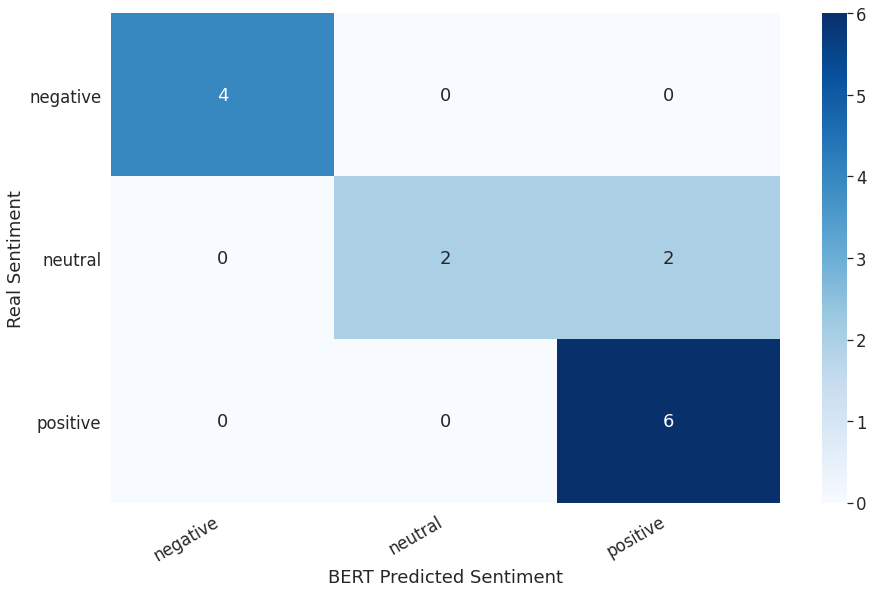

In [82]:
# Result
show_confusion_matrix(df_cm)

In [83]:
# Checking one review
idx = 0

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]

pred_df = pd.DataFrame(
    {
        'class_names': class_names,
        'values': y_pred_probs[idx]
    }
)

In [84]:
print("\n".join(wrap(review_text)))
print()
print(f'Real Sentiment: {class_names[true_sentiment]}')

I'm having trouble uploading docs and files. I wound appear after so
many attempts also tried restarting but still it just wouldn't upload
files and attach files in posts/message.

Real Sentiment: negative


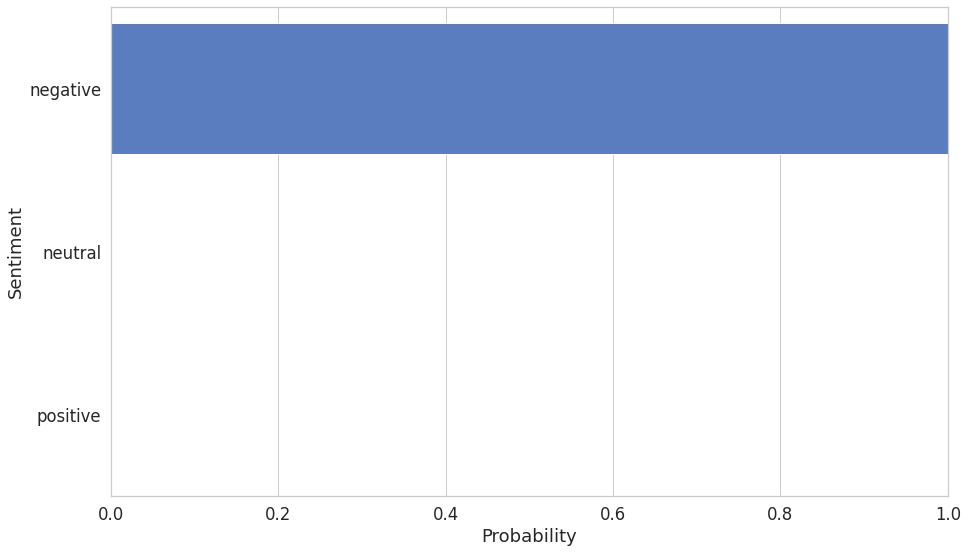

In [85]:
# Prediction plot
sns.barplot(x = 'values', y = 'class_names', data = pred_df, orient = 'h')
plt.ylabel('Sentiment')
plt.xlabel('Probability')
plt.xlim([0, 1]);

Testing with new data (s new app review).

In [86]:
test_text = 'I really love this app. It improved my work organization and efficiency'

In [87]:
# Apply the same transformation which was applied to the training data, creating the embedding object
encoded_eval = tokenizer.encode_plus(test_text,
                                     max_length = MAX_LENGTH,
                                     add_special_tokens= True,
                                     return_token_type_ids = False,
                                     pad_to_max_length = True,
                                     return_attention_mask = True,
                                     return_tensors = 'pt')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [88]:
# Extract the inputs and attention_mask to make a prediction
input_ids = encoded_eval['input_ids'].to(device)
attention_mask = encoded_eval['attention_mask'].to(device)

In [89]:
# Output (prediction)
output = model(input_ids, attention_mask)

In [90]:
# Final prediction
probability, prediction = torch.max(output, dim = 1)

In [91]:
# Print
print(f'\nApp Review Text: {test_text}')
print(f'\nSentiment: {class_names[prediction]}')
print(f'\nProbability: {probability[0]}')


App Review Text: I really love this app. It improved my work organization and efficiency

Sentiment: positive

Probability: 0.9999597072601318


# The End